In [7]:
"""
Based off of:

https://github.com/jamesmcinerney/vi_ibp/

and

https://github.com/wOOL/IBP/
"""
import numpy as np
import random
from scipy.special import psi, gamma
import sys
import os
import time

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

The IBP prior over $Z$ is used as a prior over a sparse dictionary. The data $X$ can be modeled as: $Z \sim\text{IBP}(\alpha) $, $A\sim \mathcal{N}(0, \sigma^2_{A} 1)$ and  $X\sim \mathcal{N}(ZA, \sigma^2_{X} 1)$. Where $X \in \mathbb{R}^{N \times D}$, $Z \in \mathbb{Z}_{2}^{N \times K}$ and where $A \in \mathbb{R}^{K \times D}$ and $k \in \{1, \cdots, \infty\}$. Each element in $Z$ corresponds to the presence or absence of a latent feature from $A$. $z_{ik} = 1$ corresponds to the presence of a latent feature $A_{k}$ in observation $X_{i}$.

In this notebook differnet approximations of the IBP prior are made by truncating $k$ upto some number $K$.

# Indian Buffet Prior with Matrix Fact

In [8]:
class IBP:
    """
    This implements the VI approximation with a truncation K to the IBP model.
    
    Derivations for Doshi-Velez et al. 2009. http://ai.stanford.edu/~tadayuki/papers/doshivelez-miller-vangael-teh-tech-report09.pdf
    """
    
    def __init__(self, alpha, K, N, X, D, sigma_A, sigma_n):
        # Setup
        self.alpha = alpha
        self.K = K
        self.N = N
        self.X = X
        self.D = D
        self.sigma_A = sigma_A
        self.sigma_n = sigma_n
        
        # Variational params
        self.phi = np.random.uniform(0, 1, (K, D))
        self.Phi = 0.1 * np.ones((D, D, K))
        self.nu = np.random.uniform(0, 1, (N, K))
        self.nu = self.nu/np.sum(self.nu, axis=1).reshape((-1,1)) # want contributions from features space to sum to 1
        self.tau = np.random.uniform(0, 1, (K, 2))
        self.q = np.random.uniform(0, 1, (self.K, self.K))
        
        #storage
        self.elbos = []
        self.predictive_lls = []
        
    def predictive_ll(self):
        """ Doshi-Velez does predictive ll
        
        Return:
            ll - scalar
        """
        ll = -0.5*self.D*self.N*np.log(2*np.pi*(self.sigma_n**2))
        for n in range(self.N):
            ll += -0.5*(1.0/(self.sigma_n**2)) * np.dot(self.X[n,:], self.X[n,:])

        for n in range(self.N):
            for k in range(self.K):
                ll += (1.0/(self.sigma_n**2)) * (self.nu[n, k] * np.dot(self.phi[k, :], self.X[n, :]))

        for n in range(self.N):
            for _k in range(self.K):
                for k in range(_k):
                    ll += -(1.0/(self.sigma_n**2))*(self.nu[n, k]*self.nu[n, _k]*np.dot(self.phi[k, :],\
                                                                                          self.phi[_k, :]))
    
        for k in range(self.K):
            ll += -0.5*(1.0/(self.sigma_n**2))*np.sum(self.nu[:,k]*(np.trace(self.Phi[:,:,k]) +\
                                                                      np.dot(self.phi[k, :], self.phi[k, :])))
            
        return ll
    
    def elbo(self, debug):
        """
        ELBO calculation equation 8 from "Variational Inference for the Indian Buffet Process", Doshi-Velez, 2009.
        """
        tmp1 = self.K*np.log(self.alpha) + np.sum((self.alpha - 1.)*(psi(self.tau[:, 0]) -\
                                                                  psi(self.tau[:, 0] + self.tau[:, 1])))
        
        tmp2a = 0
        for k in range(self.K):
            tmp2a += np.sum(self.nu[:,k])*(np.sum(psi(self.tau[:k, 0]) - psi(self.tau[:k, 0] + self.tau[:k, 1])))
        
        tmp2b = 0
        for k in range(self.K):
            tmpa = np.sum([np.sum(self.q[k, m+1:k])*psi(self.tau[m, 0]) for m in range(k-1)]) if k > 0 else 0
            tmpb = np.sum([np.sum(self.q[k, m:k])*psi(self.tau[m, 0]+self.tau[m, 1]) for m in range(k)]) if k > 0 else 0
            tmp2b = np.sum(1-self.nu[:, k])*(np.sum(self.q[k, :k]*psi(self.tau[:k, 1])) + tmpa \
                              - tmpb - np.sum(self.q[k, :k]*np.log(self.q[k, :k])))
        
        tmp3 = -0.5 * self.D * self.K * np.log(2*np.pi*(self.sigma_A**2))
        for k in range(self.K):
            tmp3 += -0.5*(1.0/(self.sigma_A**2))*(np.trace(self.Phi[:, :, k]) +\
                                                  np.dot(self.phi[k, :], self.phi[k, :]))

        # predictive ll term
        tmp4 = self.predictive_ll()
        
        # entropy terms
        tmp5 = np.sum(np.log(gamma(self.tau[:, 0])) + np.log(gamma(self.tau[:, 1])) \
                      - np.log(gamma(self.tau[:, 0] + self.tau[:, 1])) -\
                      (self.tau[:, 0] - 1.)*psi(self.tau[:, 0]) - (self.tau[:, 1] -1.)*psi(self.tau[:, 1]) +\
                      (self.tau[:, 0] + self.tau[:,1] - 2.)*psi(self.tau[:, 0] + self.tau[:, 1]))

        tmp6 = 0
        for k in range(self.K):
            tmp6 += 0.5*np.log(((2*np.pi*np.exp(1.0))**self.D)*np.linalg.det(self.Phi[:, :, k]))
        
        epsilon = 1e-8
        tmp6 = np.sum(-self.nu*np.log(self.nu+epsilon) - (1 - self.nu)*np.log(1-self.nu+epsilon))
        
        if debug:
            print("tmp1: {}".format(tmp1))
            print("tmp2a: {}".format(tmp2a))
            print("tmp2b: {}".format(tmp2b))
            print("tmp3: {}".format(tmp3))
            print("tmp4: {}".format(tmp4))
            print("tmp5: {}".format(tmp5))
            print("tmp6: {}".format(tmp6))
        
        return tmp1+tmp2a+tmp2b+tmp3+tmp4+tmp5+tmp6
        
                    
    def param_updates(self, rounds, debug=False):
        for t in range(rounds):
            if t % 100 == 0:
                print("Iter: {}".format(t))
            
            # Update Phi and phi
            for k in range(self.K):
                self.Phi[:, :, k] = (1.0/((1/(self.sigma_A**2))+\
                                          (1/(self.sigma_n**2)) * np.sum(self.nu[:,k]))) * np.identity(self.D)
                self.phi[k, :] = (1/self.sigma_n**2) * \
                                   np.dot(self.nu[:, k].T, self.X - np.dot(self.nu, self.phi) +\
                                          np.outer(self.nu[:, k], self.phi[k, :])) * self.Phi[0, 0, k]
                
            assert not np.isnan(self.Phi).any()
            assert not np.isnan(self.phi).any()
            
            # Update tau
            nu_sum = np.sum(self.nu, axis=0) # sums over the data points \in K
            for k in range(self.K):
                tmp = np.sum([(self.N - nu_sum[m])*np.sum(self.q[m, k+1:m+1]) for m in range(k+1, self.K)])
                self.tau[k, 0] = self.alpha + np.sum(nu_sum[k:]) + tmp
                self.tau[k, 1] = 1. + np.sum((self.N - nu_sum[k:])*self.q[k:, k])
                
            assert not np.isnan(self.tau).any()
            
            # Update nu
            # uses multinomail lower bound on E_nu[log(1-prod(v_m))]
            A = np.zeros((self.N, self.K))
            P = self.X - np.dot(self.nu, self.phi) # N x D
            v = np.zeros((self.N, self.K))
            for k in range(self.K):
                A[:, k] = np.dot(self.phi[k, :], # D
                                 np.transpose(P + np.outer(self.nu[:, k], self.phi[k, :]))
                                 ) # D x (N x D) = N
                
                # second term in multinomial approx.
                if k == 0:
                    tmp = 0
                elif k == 1:
                    tmp = self.q[1, 1]*psi(self.tau[1, 0])
                else:
                    tmp = np.sum([np.sum(self.q[k, m+1:k+1])*psi(self.tau[m, 0]) for m in range(k-1)])
                    
                if k == 0:
                    tmp1 = self.q[0,0]*psi(self.tau[0,0]+self.tau[0,1])
                elif k==1:
                    tmp1 = np.sum([np.sum(self.q[k, m:k+1])*psi(self.tau[m, 0]+self.tau[m, 1]) for m in range(k)])
                v[:, k] = np.sum(psi(self.tau[:k+1, 0]) - psi(self.tau[:k+1, 0] + self.tau[:k+1, 1])) \
                          - np.sum(self.q[k, :k+1]*psi(self.tau[:k+1, 1])) - tmp + tmp1 \
                          + np.sum(self.q[k, :k+1]*np.log(self.q[k, :k+1])) \
                          - (0.5/(self.sigma_n**2))*(np.trace(self.Phi[:,:,k]) \
                          + np.dot(self.phi[k, :], self.phi[k, :])) + (1/(self.sigma_n**2))*A[:,k]

            self.nu = 1.0 / (1.0 + np.exp(-v))
        
            assert not np.isnan(self.nu).any()
            
            # Using multinomial approximation (q) for optimisation on E_nu[log(1-prod(v_m))]
            for k in range(self.K):
                self.q[k, 0] = np.exp(psi(self.tau[0,1])-psi(self.tau[0,0]+self.tau[0,1]))
                for j in range(1, self.K):
                    self.q[k, j] = np.exp(psi(self.tau[j,1])+np.sum(psi(self.tau[:j,0])) -\
                                     np.sum(psi(self.tau[:j+1,0]+self.tau[:j+1,1])))
            self.q = self.q/np.sum(self.q, axis=1).reshape((-1,1)) # want contributions from features space to sum to 1
            
            assert not np.isnan(self.q).any()
            
            if t % 10 == 0:
                self.predictive_lls.append(self.predictive_ll())
                self.elbos.append(self.elbo(debug=debug))
                
                if debug:
                    plt.hist(self.tau[:,0].flatten())
                    plt.title("Variational $\\tau_1$")
                    plt.show()
                    
                    plt.hist(self.tau[:,1].flatten())
                    plt.title("Variational $\\tau_2$")
                    plt.show()
                    
                    plt.hist(self.q.flatten())
                    plt.title("Lagrangian params")
                    plt.show()
                    
                    plt.imshow(self.q)
                    plt.title("Lagrandian params")
                    plt.colorbar()
                    plt.show()
                    
                    plt.hist(self.nu.flatten())
                    plt.title("Variational $\\nu$")
                    plt.show()
                    
                    plt.hist(self.phi.flatten())
                    plt.title("Variational $\\phi$")
                    plt.show()
                    
                    plt.imshow(self.tau)
                    plt.title("$\\tau$")
                    plt.colorbar()
                    plt.show()
            

# Image dataset

In [9]:
def generate_synthetic_data(N, K, d1, d2):
    """
    Generates synthetic dataset of images with a fixed basis
    
    X = Zs
    X \in NxD
    Z \in NxK
    s \in KxD
    
    D = d1xd2
    
    Args:
        N: number of points in the data set
        K: number of underlying features
        d1: length of first dimension
        d2: length of second dimension
        
    Returns:
        s: array K x D dictionary of features
        X: synthetically generated dataset
        
    """
    D = d1*d2
    
    #define some shapes
    s = np.zeros((K,D))

    assert K == 8, "we have 8 dims for K"

    s[0,:] = np.array([[0,0,1,0],
                       [1,1,1,1],
                       [0,0,1,0],
                       [0,0,0,0]]).flatten()
    s[1,:] = np.array([[0,1,0,0],
                       [0,1,0,0],
                       [0,1,0,0],
                       [0,1,0,0]]).flatten()
    s[2,:] = np.array([[1,1,1,1],
                       [0,0,0,0],
                       [0,0,0,0],
                       [0,0,0,0]]).flatten()
    s[3,:] = np.array([[1,0,0,0],
                       [0,1,0,0],
                       [0,0,1,0],
                       [0,0,0,1]]).flatten()
    s[4,:] = np.array([[0,0,0,0],
                       [0,0,0,0],
                       [1,1,0,0],
                       [1,1,0,0]]).flatten()
    s[5,:] = np.array([[1,1,1,1],
                       [1,0,0,1],
                       [1,0,0,1],
                       [1,1,1,1]]).flatten()
    s[6,:] = np.array([[0,0,0,0],
                       [0,1,1,0],
                       [0,1,1,0],
                       [0,0,0,0]]).flatten()
    s[7,:] = np.array([[0,0,0,1],
                       [0,0,0,1],
                       [0,0,0,1],
                       [0,0,0,1]]).flatten()

    pr_z = 0.2
    w = np.random.uniform(0.5, 1.0, K) # weight of features
    mut = w[:,np.newaxis]*s
    z = np.random.binomial(1, pr_z, (N, K)) # each feature occurs with prob 0.2 independently 
    X = np.dot(z,mut) + np.random.randn(N, D)*0.1 

    return s, X

def lof(nu, probs=True):
    """Left ordering of binary matrix
    """
    if probs:
        Z = np.random.binomial(1, nu, nu.shape)
    else:
        Z = np.copy(nu)
    x = np.linspace(0, nu.shape[0]-1, nu.shape[0])
    xx, yy = np.meshgrid(x, x)
    exponent = nu.shape[0]-1-yy[:, :nu.shape[1]]
    magnitude = np.multiply(2**exponent, Z)
    full_Z = Z[:, np.sum(magnitude, axis=0).argsort()[::-1]] # reverse the sorting so that largest first!
    idy = np.flatnonzero(np.sum(full_Z, axis=0))
    non_zero_cols_Z= full_Z[:, idy]
    idx = np.flatnonzero(np.sum(non_zero_cols_Z, axis=1))
    return non_zero_cols_Z[idx, :]

In [10]:
def plot_grid(X, d1, d2, final=0, title='', order='C'):
    #takes a NxD matrix and plots N d1xd2 images (where d1xd2==D)
    (N,D) = np.shape(X)
    n1 = int(np.sqrt(N))+1
    fig, ax = plt.subplots(n1, n1)
    n = 0
    for i in range(n1):
        for j in range(n1):
            if n >= N: break
            imgplot = ax[i,j].imshow(np.reshape(X[n,:], (d1,d2), order=order).T,
                                     cmap=cm.Greys_r) #, vmin=0, vmax=2)
            imgplot.set_interpolation('nearest')
            n += 1 
    fig.suptitle(title)
    fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


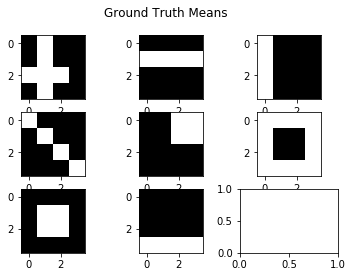

In [11]:
##################################
## Generate synthetic dataset 1 ##
##################################
N = 100
d1, d2 = 4, 4
D = d1*d2
K = 8
dictionary, X = generate_synthetic_data(N, K, d1, d2)
plot_grid(dictionary, d1, d2, title='Ground Truth Means')

# Truncated Stick-Breaking Construction Variational Approach

In [12]:
#######################
## Model Hyperparams ##
#######################
K = 15
sigma_A = 0.35
sigma_n = 0.1
#alpha = 0.7
alphas = [0.5, 1.0]


#############################
## Optimization parameters ##
#############################
rounds = 500
#elbos = []
elbos = {alpha: [] for alpha in alphas}
lls = {alpha: [] for alpha in alphas}
phis = {}
nus = {}
starts = 5

######################
## Run Optimization ##
######################

for alpha in alphas:
    for i in range(starts):
        ibp_model = IBP(alpha, K, N, X, D, sigma_A, sigma_n)
        ibp_model.param_updates(rounds, debug=False)
        elbos[alpha].append(ibp_model.elbos)
        lls[alpha].append(ibp_model.predictive_lls)
    phis[alpha] = ibp_model.phi
    nus[alpha] = ibp_model.nu

Iter: 0


/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in subtract
/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:145: RuntimeWarning: overflow encountered in exp


Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400


/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/skessler/anaconda2/envs/py36/lib/python3.6/sit

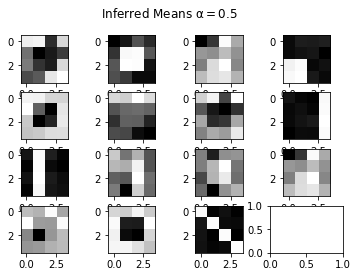

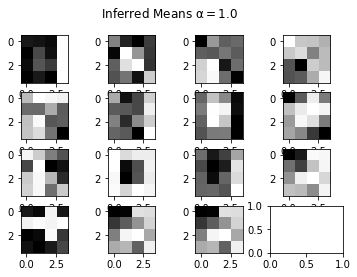

In [13]:
# The means of the Gaussian dictionary should contain the
# useful for the second synthetic example.
for alpha in alphas:
    plot_grid(phis[alpha], d1, d2, title='Inferred Means $\\alpha = {}$'.format(alpha), order='F')

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


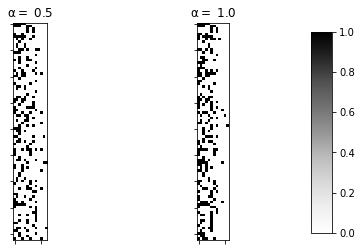

In [17]:
fig, ax = plt.subplots(1, len(alphas))
if len(alphas) > 1:
    n = 0
    for i in range(len(alphas)):
        alpha = alphas[i]
        imgplot = ax[i].imshow(lof(nus[alpha][:100,:], probs=True), cmap=cm.Greys, vmin=0, vmax=1) # cmap=cm.Greys_r,
        #imgplot.set_interpolation('nearest')
        ax[i].set_title('$\\alpha = $ {}'.format(alpha))
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        #ax[i].set_aspect('equal')
else:
    alpha = alphas[i]
    imgplot = ax.imshow(lof(nus[alpha][:100, :], probs=True), cmap=cm.Greys, vmin=0, vmax=1) # cmap=cm.Greys_r,
    ax.set_title('$\\alpha = $ {}'.format(alpha))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(imgplot, cax=cbar_ax)
fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


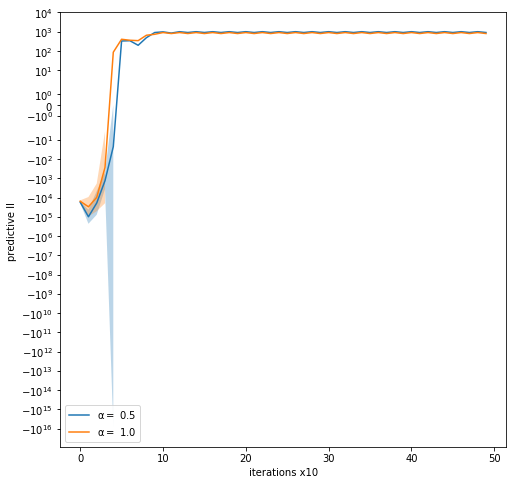

In [18]:
def transform(theta):
    return np.log(-theta)

def delta_method(se, theta):
    return se / theta

def back_transform(phi):
    return -np.exp(phi)

means = {}
stds = {}
stds_trans_upper = {}
stds_trans_lower = {}
for alpha in alphas:
    thetas = [np.mean(a) for a in zip(*lls[alpha])]
    stds_theta = [np.std(a) for a in zip(*lls[alpha])]
    means[alpha] = thetas
    stds[alpha] = stds_theta
    stds_phi = [delta_method(se, theta) for se, theta in zip(stds_theta, thetas)]
    phi_upper = [transform(ll) + ll_sd_phi for ll, ll_sd_phi in zip(thetas, stds_phi)]
    phi_lower = [transform(ll) - ll_sd_phi for ll, ll_sd_phi in zip(thetas, stds_phi)]
    theta_trains_upper = [back_transform(phi) for phi in phi_upper]
    theta_trans_lower = [back_transform(phi) for phi in phi_lower]
    stds_trans_upper[alpha] = theta_trains_upper
    stds_trans_lower[alpha] = theta_trans_lower
    
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for alpha in alphas:
    ax.plot(means[alpha], label='$\\alpha = $ {}'.format(alpha))
    ax.fill_between(list(range(len(means[alpha]))),
                   stds_trans_upper[alpha],
                   stds_trans_lower[alpha], alpha=0.3)
    
ax.set_yscale('symlog')
plt.xlabel("iterations x10")
plt.ylabel("predictive ll ")
plt.legend()
plt.show()